In [22]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
class CFG1:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.1
  iterations = 1000
  experiments = 2000

In [24]:
class kArmedTestBed:
  def __init__(self, cfg):
    self.cfg = cfg
    self.k = cfg.k
    self.actions = [i for i in range(1, self.k + 1)]
    self.reward_means = cfg.reward_means
    self.reward_stds = cfg.reward_stds
    self.rewards_store = [[] for _ in range(self.k)]

  def populate_rewards(self, samples_per_distribution=1000):
    for action in range(self.k):
      for _ in range(samples_per_distribution):
        self.rewards_store[action].append(self.claim_reward(action))

  def rewards(self):
    return self.rewards_store

  def claim_reward(self, action):
    return torch.normal(self.reward_means[action], self.reward_stds[action]).item()

  def plot_rewards_distribution(self):
    data = [self.rewards_store[i] for i in range(self.k)]

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data, inner="quartile", color='#4A90E2', edgecolor='#2E6DA4')
    plt.xticks(ticks=range(self.k), labels=self.actions)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Action')
    plt.ylabel('Reward distribution')
    plt.title('Reward Distribution by Action')

    plt.tight_layout()
    plt.show()

In [25]:
class Bandit:
  def __init__(self, cfg):
    self.k = cfg.k
    self.actions = [i for i in range(self.k)]
    self.test_bed = kArmedTestBed(cfg)
    self.test_bed.populate_rewards()
    self.Q = [0 for i in range(self.k)]
    self.N = [0 for i in range(self.k)]
    self.eps = cfg.eps
    self.rewards_accumulated = []
    self.iterations = cfg.iterations

  def one_run(self):
    if random.random() < self.eps:
      action = random.choice(self.actions)
    else:
      action = np.argmax(self.Q)

    reward = self.test_bed.claim_reward(action)
    self.rewards_accumulated.append(reward)
    self.N[action] += 1
    self.Q[action] = self.Q[action] + (1 / self.N[action]) * (reward - self.Q[action])

  def run_experiment(self):
    for _ in range(self.iterations):
      self.one_run()

In [26]:
class Experiment:
  def __init__(self, cfg):
    self.cfg = cfg
    self.experiments = cfg.experiments
    self.bandits = []
    self.accumulated_rewards_store = []
    self.averaged_rewards = None

  def run(self):
    for _ in range(self.experiments):
      bandit = Bandit(self.cfg)
      self.bandits.append(bandit)
      bandit.run_experiment()
      self.accumulated_rewards_store.append(bandit.rewards_accumulated)

    self.averaged_rewards = list(np.mean(self.accumulated_rewards_store, axis=0))

  def plot_average_rewards(self):
    plt.figure(figsize=(12, 6))
    plt.plot(self.averaged_rewards, linewidth=2, color='blue')
    plt.xlabel('Steps', fontsize=14)
    plt.ylabel('Average Reward', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

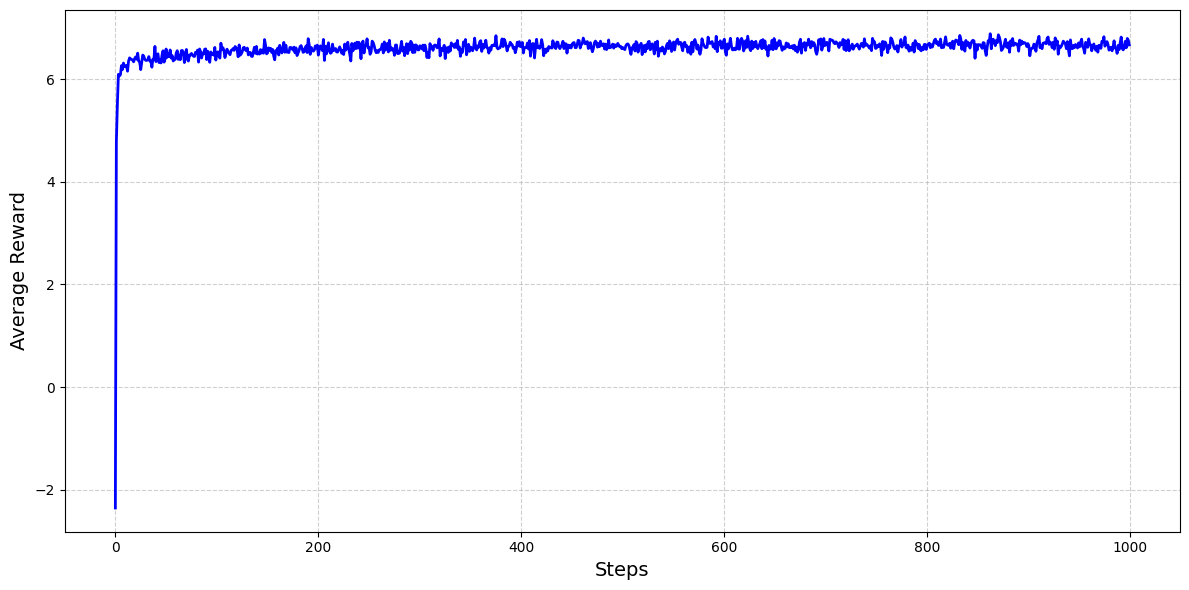

In [27]:
experiment = Experiment(CFG1)
experiment.run()
experiment.plot_average_rewards()

averaged_rewards_epsilon_greedy = experiment.averaged_rewards

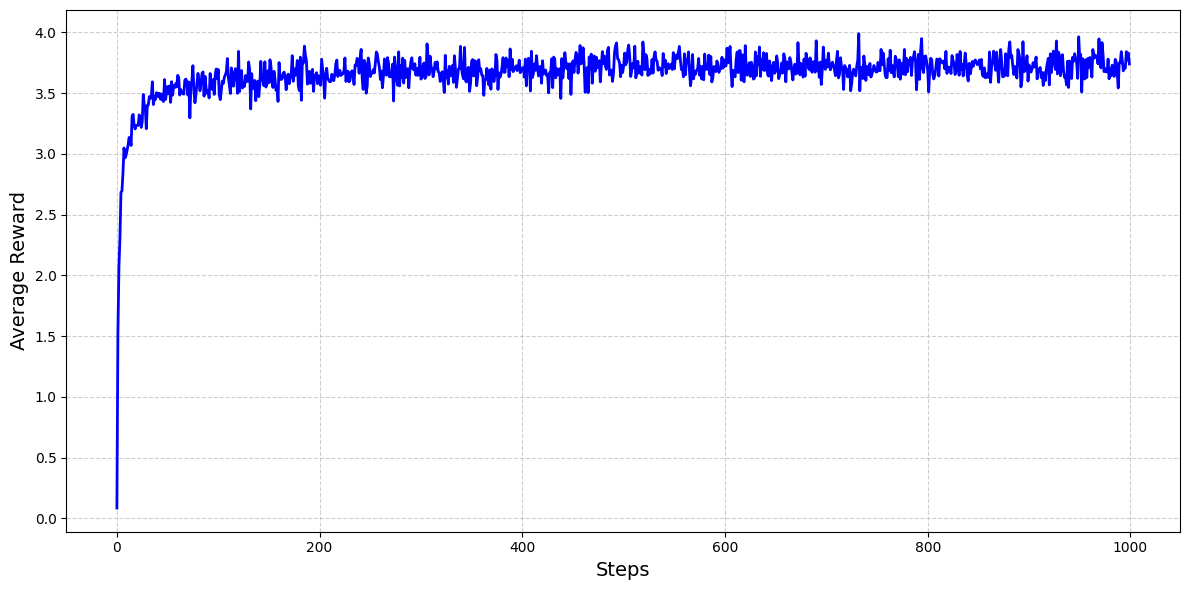

In [28]:
class CFG2:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.0
  iterations = 1000
  experiments = 2000

experiment = Experiment(CFG2)
experiment.run()
experiment.plot_average_rewards()

averaged_rewards_greedy = experiment.averaged_rewards

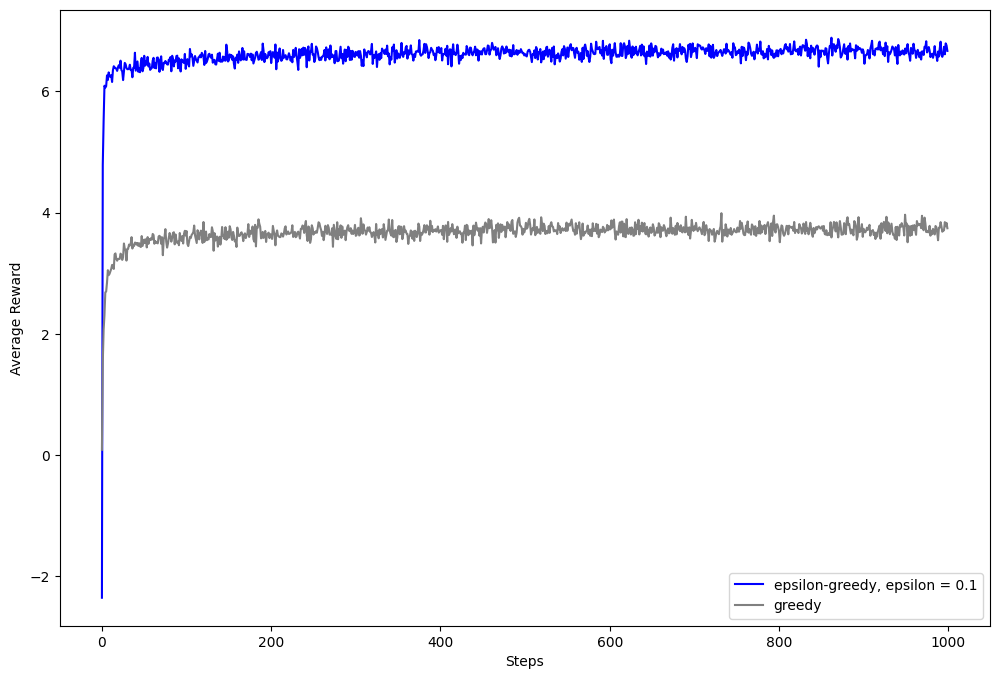

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(averaged_rewards_epsilon_greedy, color='blue', label='epsilon-greedy, epsilon = 0.1')
plt.plot(averaged_rewards_greedy, color='grey', label='greedy')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

In [34]:
results = {
    'experiment_1': {
        'exploration': 'epsilon-greedy',
        'CFG': CFG1,
        'averaged_rewards': averaged_rewards_epsilon_greedy
    },
    'experiment_2': {
        'exploration': 'greedy',
        'CFG': CFG2,
        'averaged_rewards': averaged_rewards_greedy
    }
}

In [33]:
class CFG2:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.0
  iterations = 1000
  experiments = 2000

In [35]:
results

{'experiment_1': {'exploration': 'epsilon-greedy',
  'CFG': __main__.CFG1,
  'averaged_rewards': [np.float64(-2.357609000772238),
   np.float64(4.78598654705286),
   np.float64(5.5125853671729566),
   np.float64(6.093806611895562),
   np.float64(6.063501840561629),
   np.float64(6.086181157171726),
   np.float64(6.263527250260115),
   np.float64(6.188240961879492),
   np.float64(6.3132143123149875),
   np.float64(6.250569450318813),
   np.float64(6.2414697265625),
   np.float64(6.2687349230349065),
   np.float64(6.155493315368891),
   np.float64(6.349017325222492),
   np.float64(6.4150337023437025),
   np.float64(6.396153343230486),
   np.float64(6.38438283675909),
   np.float64(6.372915641844273),
   np.float64(6.338510043740272),
   np.float64(6.400412990450859),
   np.float64(6.432670993208885),
   np.float64(6.388805978506803),
   np.float64(6.5070212193131445),
   np.float64(6.35299676156044),
   np.float64(6.330522962480783),
   np.float64(6.186721239417792),
   np.float64(6.3280

In [36]:
import pickle

with open('results_12.pkl', 'wb') as f:
    pickle.dump(results, f)